# CNN-BERT (baseline)


<a id="Table-of-Contents"></a>
## Table of Contents
- [Section 1: Hyperparameters](#Hyperparameters)
- [Section 2: Data Preprocessing](#Data-Preprocessing)
- [Section 3: Training Function](#Training-Function)
- [Section 4: Training & Evaluation Results](#Training-and-Evaluation)

## Installing the required dependencies

In [ ]:
!pip install torch transformers[torch] accelerate evaluate --quiet

In [ ]:
# pip install pandas==1.5.3 --quiet

In [ ]:
# pip install datasets --quiet

In [ ]:
# pip install evaluate --quiet

In [ ]:
import os
import io
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
%matplotlib inline
import re
from ast import literal_eval

import torch
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

import string
from itertools import combinations

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import transformers
from transformers import (
    AutoModel,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    TrainerCallback,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    BertModel,
    BertTokenizer,
    BertConfig
)

import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from typing import List, Optional, Tuple, Union
from transformers.modeling_outputs import SequenceClassifierOutput
import seaborn as sns
import wandb

from datasets import load_metric
import evaluate

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2024-05-20 08:29:43.713006: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 08:29:43.713104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 08:29:43.860669: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<a id="Hyperparameters"></a>
## Hyperparameters

[Back to Top](#Table-of-Contents)

In [ ]:
dataset_path = '/kaggle/input/cognitive-distortions-data/Cognitive Distortions Data with DA.csv'


classification = 2
val_pct, test_pct = 0.3, 2/3

model_name = "bert-base-uncased"

is_CNN = True

annotator_col = 'annotator'

# Training Args
epochs = 20
train_batch_size = 300
eval_batch_size = 300
# lr = 4e-5 if model_name == "roberta-base" else 5e-5
out_dir = "cnnbert"

# early stopping hyperparameters
e_stop_epochs = 2
e_stop_patience = 0.01

# loading the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

# specifying the padding token
if model_name != "bert-base-uncased":
    pad_token = tokenizer.eos_token
    tokenizer.pad_token = pad_token

# global var to be used across functions
encoder = LabelEncoder()

api_key = ""
wandb.login(key=api_key)

g1 = 'Blaming/Always Being Right/Fallacy of Fairness/Global Labelling/Jumping to Conclusions'
g2 = 'Overgeneralization/Catastrophizing/Polarization'
g3 = 'Emotional Reasoning/Control of Fallacies/Fallacy of Change/Mental Filtering'
new_categories = {
    'blaming': g1,
    'overgeneralization': g2,
    'personalization': 'personalization',
    'catastrophizing': g2,
    'jumping to conclusions': g1,
    'mental filtering': g3,
    'emotional reasoning': g3,
    'polarization': g2,
    'shoulds': 'shoulds',
    'fallacy of fairness': g1,
    'control of fallacies': g3,
    'fallacy of change': g3,
    'global labelling': g1,
    'always being right': g1
}

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

<a id="Data-Preprocessing"></a>
## Data Preprocessing

[Back to Top](#Table-of-Contents)

In [ ]:
def update_sentence_augmentation(df, is_sr_ri=False):
    df = df.melt(id_vars=[annotator_col], value_name='text')

    def replace_rows(df):
        new_rows = []
        for index, row in df.iterrows():
            if row['variable'] == 'SR_RI':
                lst = literal_eval(row['text'])
                for i, sentence in enumerate(lst):
                    # selecting 1 SR & 1 RI to limit to max 2 augmentations
                    if i % 2 == 0:
                        new_row = row.copy()
                        new_row['text'] = sentence
                        new_rows.append(new_row)
            else:
                new_rows.append(row)
        return pd.DataFrame(new_rows)

    if (is_sr_ri == True):
        df = replace_rows(df)
    return df

In [ ]:
def text_and_col_processing(df, txt_col_name: str):
    stpwrds = list(string.punctuation)
    # stemmer = PorterStemmer()

    # Lowering, Removing Punctuations & Stopwords, Stemming
    def preprocess_text(sent):
        return ' '.join([word.lower() for word in sent.split() if word.lower() not in stpwrds])

    df[txt_col_name] = df[txt_col_name].apply(preprocess_text)

    # Find sentences that became empty after preprocessing
    empty_sentences_indices = df[df[txt_col_name].apply(len) == 0].index
    df.drop(empty_sentences_indices, inplace=True)
    df.reset_index(drop=True, inplace=True)

    # performing label encoding the annotator classes
    df['annotator_encoded'] = encoder.fit_transform(df[annotator_col])

    # renaming the columns in the format accepted by the transformer
    df[['label', 'text']] = df[['annotator_encoded', txt_col_name]]

    # dropping unnecessary columns
    df = df[['label', 'text']]

    return df

In [ ]:
# preprocess_data function
def preprocess_data(df, classification, cols_to_select, val_pct, test_pct):

    df[annotator_col] = df[annotator_col].str.lower()
    cols_to_select.append(annotator_col)
    df = df[cols_to_select].dropna()

    match classification:
        case 2:
            df[annotator_col] = df[annotator_col].apply(lambda x: 'neutral' if x == 'neutral' else 'distorted')
        case 14:
            df = df[df[annotator_col] != 'neutral']
        case 5:
            df = df[df[annotator_col] != 'neutral']
            df[annotator_col] = df[annotator_col].map(new_categories)
        case _:
            raise Exception("Invalid Classification Type!\n")

    # performing stratified splitting to the dataset with 70/10/20 train-val-test ratio
    train, val = train_test_split(df, test_size=val_pct, random_state=42, shuffle=True, stratify = df[annotator_col])
    val, test = train_test_split(val, test_size=test_pct, random_state=42, stratify = val[annotator_col])

    is_sr_ri = True if 'SR_RI' in cols_to_select else False
    train = update_sentence_augmentation(train, is_sr_ri)

    train = text_and_col_processing(train, txt_col_name="text")
    val = text_and_col_processing(val, txt_col_name="sentence")
    test = text_and_col_processing(test, txt_col_name="sentence")

    train.to_csv("train.csv", index=False)
    val.to_csv("val.csv", index=False)
    test.to_csv("test.csv", index=False)

    # creating a dictionary of train and eval datasets
    data_files = {
        "train": "/kaggle/working/train.csv",
        "eval": "/kaggle/working/val.csv",
        "test": "/kaggle/working/test.csv"
    }

    # loading the datasets into a hugging face dataset object
    cognitive_dataset = load_dataset("csv", data_files=data_files)

    # Tokenization function with padding set to the longest sequence length
    def tokenize_function(examples):
        if is_CNN == True:
            return tokenizer(examples["text"], return_tensors="pt", max_length=300, padding='max_length', truncation=True, add_special_tokens=True)
        return tokenizer(examples["text"], truncation=True, add_special_tokens=True)

    # Tokenizing the dataset
    tokenized_datasets = cognitive_dataset.map(tokenize_function, batched=True)


    return tokenized_datasets['train'], tokenized_datasets['eval'], tokenized_datasets['test']

<a id="Training-Function"></a>
## Training Function

[Back to Top](#Table-of-Contents)

In [ ]:
class CustomBERTClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(CustomBERTClassifier, self).__init__()
        self.base_model = AutoModel.from_pretrained(model_name)
        self.n_conv_1 = self.n_conv_2 = self.n_conv_3 = 512
        self.k_conv_1 = 4
        self.k_conv_2 = 3
        self.k_conv_3 = 5
        self.num_labels = num_labels

        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=self.n_conv_1, kernel_size=(self.k_conv_1, 768))
        self.maxp_1 = nn.MaxPool2d(kernel_size=(297, 1))

        self.conv_2 = nn.Conv2d(in_channels=1, out_channels=self.n_conv_2, kernel_size=(self.k_conv_2, 768))
        self.maxp_2 = nn.MaxPool2d(kernel_size=(298, 1))

        self.conv_3 = nn.Conv2d(in_channels=1, out_channels=self.n_conv_3, kernel_size=(self.k_conv_3, 768))
        self.maxp_3 = nn.MaxPool2d(kernel_size=(296, 1))

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.2)

        self.fc = nn.Linear(self.n_conv_1 + self.n_conv_2 + self.n_conv_3, self.num_labels)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):

        outputs = self.base_model(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )
        x = outputs.last_hidden_state.unsqueeze(1)

        conv1_out = F.relu(self.conv_1(x))
        maxp1_out = self.maxp_1(conv1_out)

        conv2_out = F.relu(self.conv_2(x))
        maxp2_out = self.maxp_2(conv2_out)

        conv3_out = F.relu(self.conv_3(x))
        maxp3_out = self.maxp_3(conv3_out)

        concat = torch.cat((maxp1_out, maxp2_out, maxp3_out), dim=1)

        flatten_out = self.flatten(concat)
        dropout_out = self.dropout(flatten_out)

        logits = self.fc(dropout_out)

        outputs = (logits,) + outputs[2:]

        if labels is not None:
            if self.num_labels == 1:
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs

In [ ]:
def plot_cm(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
def train(train, val, test):
    # loading the model and adding it to the GPU
    model = CustomBERTClassifier(model_name=model_name, num_labels=classification)
    model.to(device)
    for param in model.base_model.parameters():
        param.requires_grad = False

    # Load metrics
    f1_metric = evaluate.load("f1")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")
    accuracy_metric = evaluate.load("accuracy")

    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predictions = F.softmax(torch.tensor(predictions), dim=1).numpy()
        predictions = np.argmax(predictions, axis=1)

        # Compute each metric
        f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')
        precision = precision_metric.compute(predictions=predictions, references=labels, average='weighted', zero_division=0)
        recall = recall_metric.compute(predictions=predictions, references=labels, average='weighted')
        accuracy = accuracy_metric.compute(predictions=predictions, references=labels)

        return {
            "f1": f1['f1'],
            "precision": precision['precision'],
            "recall": recall['recall'],
            "accuracy": accuracy['accuracy']
        }


    # learning rate was chosing after conducting a hyperparameter search
    training_args = TrainingArguments(
        output_dir=out_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",

        num_train_epochs=epochs,

        per_device_train_batch_size=train_batch_size,
        per_device_eval_batch_size=eval_batch_size,
#         learning_rate=lr,
        load_best_model_at_end=True,
    )


    early_stopping = EarlyStoppingCallback(e_stop_epochs, e_stop_patience)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    trainer = Trainer(
#             model_init=model_init,
            model=model,
            args=training_args,
            train_dataset=train,
            eval_dataset=val,
            tokenizer=tokenizer,
#             data_collator=data_collator,
            optimizers=(torch.optim.Adamax(model.parameters()), None),
            compute_metrics=compute_metrics,
            callbacks=[early_stopping]
        )

    print("Training Started!")
    trainer.train()

    trainer.evaluate()

    predictions = trainer.predict(test)

    true_labels = test["label"]
    predicted_labels = predictions.predictions.argmax(axis=1)

    y_true_original = encoder.inverse_transform(true_labels)
    predictions_original = encoder.inverse_transform(predicted_labels)

    print("Classification Report:")
    print(classification_report(y_true_original, predictions_original))

    print("Confusion Matrix:")
    plot_cm(true_labels, predicted_labels)
    del model, trainer

<a id="Training-and-Evaluation"></a>
## Training & Evaluation Results

[Back to Top](#Table-of-Contents)

,sentence


Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/24717 [00:00<?, ? examples/s]

Map:   0%|          | 0/3531 [00:00<?, ? examples/s]

Map:   0%|          | 0/7063 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Currently logged in as: 18063 (gpt2_aug). Use `wandb login --relogin` to force relogin


Training Started!


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.486349,0.747897,0.749206,0.747097,0.747097
2,No log,0.463207,0.761000,0.767018,0.759275,0.759275
3,No log,0.454405,0.772352,0.772403,0.772302,0.772302
4,No log,0.456472,0.768590,0.778951,0.766638,0.766638


Classification Report:
              precision    recall  f1-score   support

   distorted       0.72      0.74      0.73      2877
     neutral       0.82      0.80      0.81      4186

    accuracy                           0.78      7063
   macro avg       0.77      0.77      0.77      7063
weighted avg       0.78      0.78      0.78      7063

Confusion Matrix:


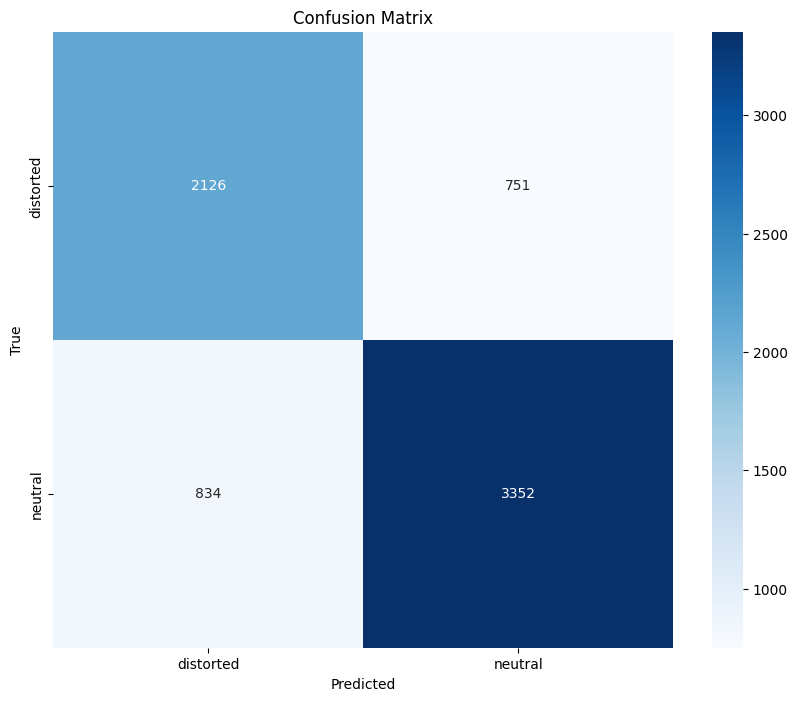

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


,sentence,WE_Sub_BERT


Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/49434 [00:00<?, ? examples/s]

Map:   0%|          | 0/3531 [00:00<?, ? examples/s]

Map:   0%|          | 0/7063 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Training Started!


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.493380,0.738514,0.748219,0.736335,0.736335
2,No log,0.472203,0.748976,0.751966,0.753611,0.753611
3,No log,0.466696,0.761874,0.761572,0.763240,0.763240
4,0.582400,0.471896,0.757651,0.760381,0.761824,0.761824


Classification Report:
              precision    recall  f1-score   support

   distorted       0.74      0.70      0.72      2877
     neutral       0.80      0.83      0.82      4186

    accuracy                           0.78      7063
   macro avg       0.77      0.77      0.77      7063
weighted avg       0.78      0.78      0.78      7063

Confusion Matrix:


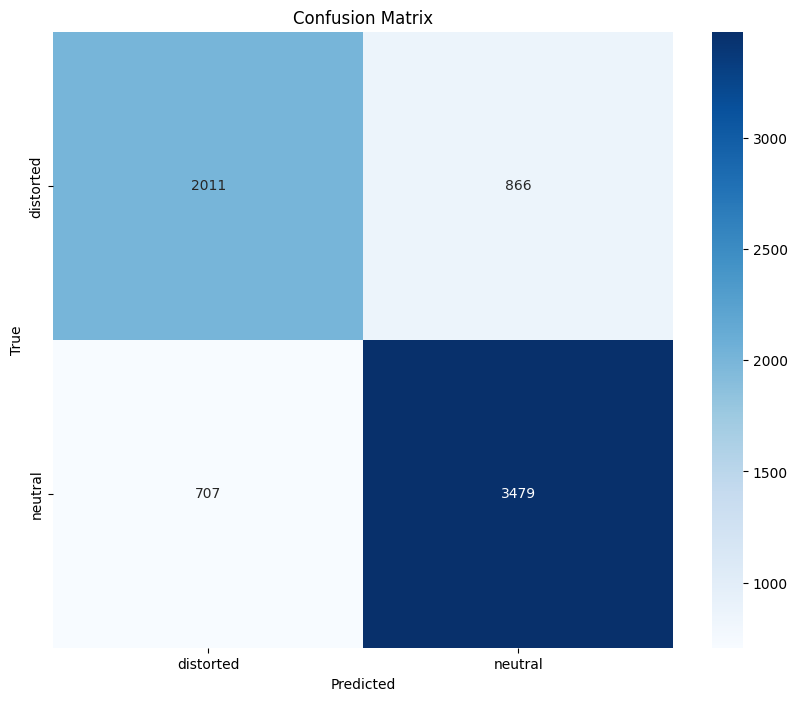

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


,sentence,SR_RI


Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/74149 [00:00<?, ? examples/s]

Map:   0%|          | 0/3531 [00:00<?, ? examples/s]

Map:   0%|          | 0/7063 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Training Started!


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.472553,0.755699,0.755431,0.757293,0.757293
2,No log,0.459737,0.763892,0.770748,0.762107,0.762107
3,0.572500,0.447959,0.773185,0.774135,0.772586,0.772586
4,0.572500,0.459816,0.765383,0.765008,0.766072,0.766072
5,0.442700,0.472569,0.767850,0.768883,0.767205,0.767205


Classification Report:
              precision    recall  f1-score   support

   distorted       0.72      0.76      0.74      2877
     neutral       0.83      0.80      0.81      4186

    accuracy                           0.78      7063
   macro avg       0.78      0.78      0.78      7063
weighted avg       0.79      0.78      0.78      7063

Confusion Matrix:


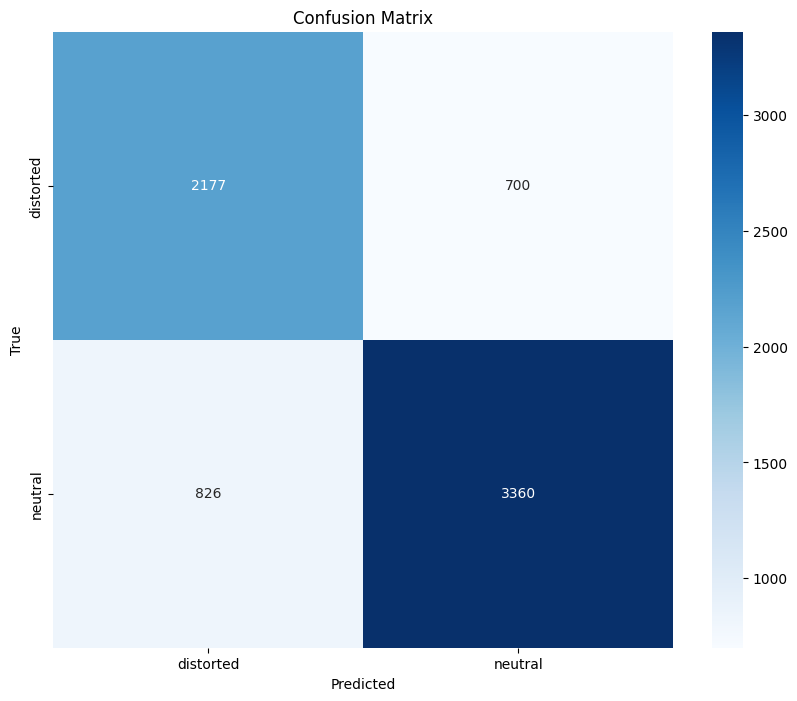

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


,sentence,BT_Opus_MT


Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/49434 [00:00<?, ? examples/s]

Map:   0%|          | 0/3531 [00:00<?, ? examples/s]

Map:   0%|          | 0/7063 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Training Started!


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.477109,0.754288,0.765206,0.752195,0.752195
2,No log,0.459322,0.764008,0.772505,0.770603,0.770603
3,No log,0.445500,0.772837,0.774354,0.772019,0.772019
4,0.517700,0.461011,0.768176,0.772595,0.772869,0.772869
5,0.517700,0.474766,0.775855,0.777485,0.778816,0.778816


Classification Report:
              precision    recall  f1-score   support

   distorted       0.72      0.77      0.74      2877
     neutral       0.83      0.79      0.81      4186

    accuracy                           0.78      7063
   macro avg       0.78      0.78      0.78      7063
weighted avg       0.79      0.78      0.78      7063

Confusion Matrix:


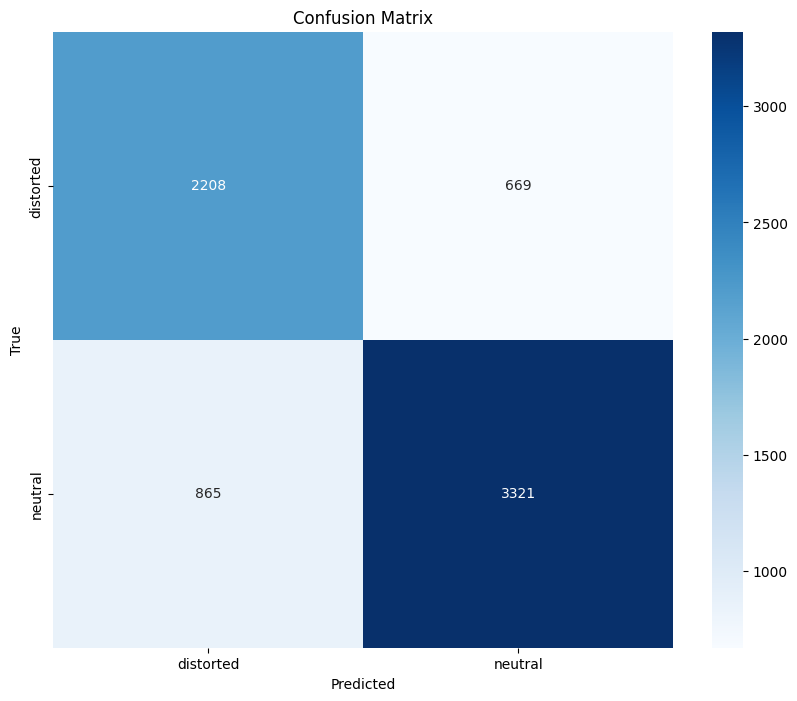

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


,sentence,WE_Sub_BERT,SR_RI


Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/98866 [00:00<?, ? examples/s]

Map:   0%|          | 0/3531 [00:00<?, ? examples/s]

Map:   0%|          | 0/7063 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Training Started!


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.476348,0.754039,0.760741,0.752195,0.752195
2,0.597900,0.468077,0.747836,0.755817,0.755027,0.755027
3,0.597900,0.462917,0.768760,0.768403,0.769754,0.769754


Classification Report:
              precision    recall  f1-score   support

   distorted       0.74      0.71      0.73      2877
     neutral       0.81      0.83      0.82      4186

    accuracy                           0.78      7063
   macro avg       0.78      0.77      0.77      7063
weighted avg       0.78      0.78      0.78      7063

Confusion Matrix:


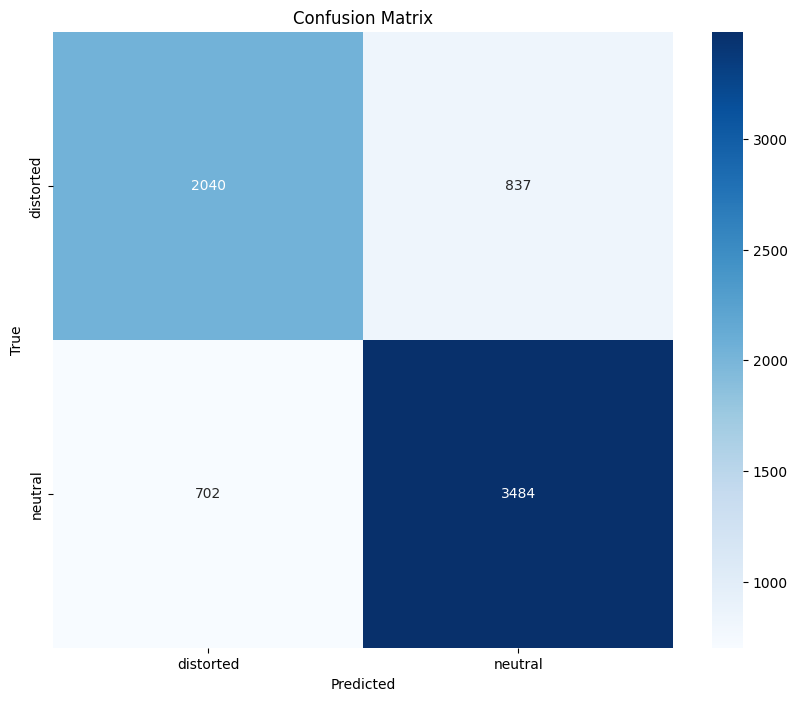

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


,sentence,WE_Sub_BERT,BT_Opus_MT


Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/74151 [00:00<?, ? examples/s]

Map:   0%|          | 0/3531 [00:00<?, ? examples/s]

Map:   0%|          | 0/7063 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Training Started!


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.472058,0.757359,0.759191,0.760974,0.760974
2,No log,0.502506,0.731393,0.769982,0.749646,0.749646
3,0.564000,0.449891,0.771670,0.771412,0.772019,0.772019
4,0.564000,0.457455,0.769249,0.769315,0.769187,0.769187
5,0.438000,0.496361,0.762954,0.763595,0.765506,0.765506


Classification Report:
              precision    recall  f1-score   support

   distorted       0.73      0.73      0.73      2877
     neutral       0.82      0.81      0.81      4186

    accuracy                           0.78      7063
   macro avg       0.77      0.77      0.77      7063
weighted avg       0.78      0.78      0.78      7063

Confusion Matrix:


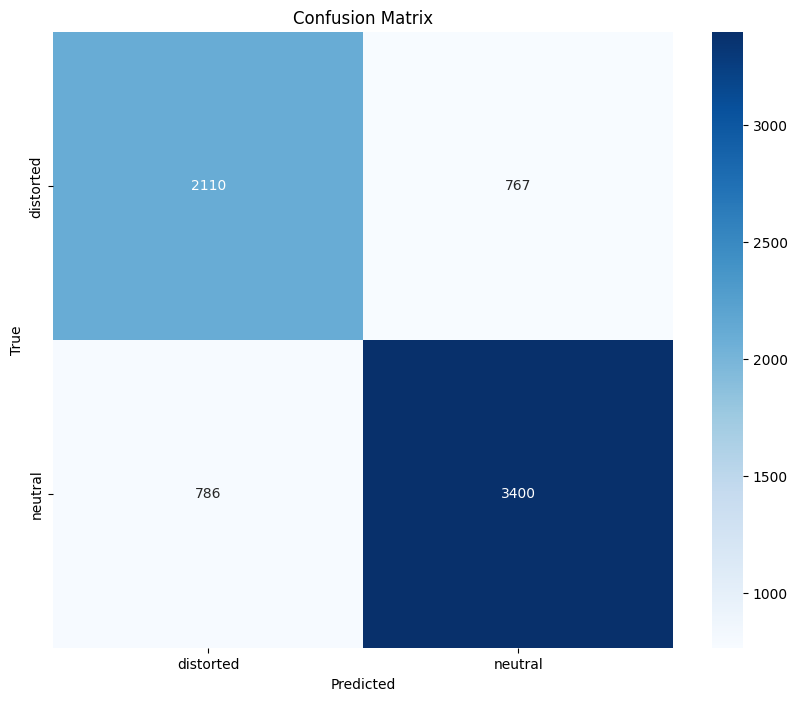

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


,sentence,SR_RI,BT_Opus_MT


Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/98866 [00:00<?, ? examples/s]

Map:   0%|          | 0/3531 [00:00<?, ? examples/s]

Map:   0%|          | 0/7063 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Training Started!


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.467256,0.746810,0.752602,0.753044,0.753044
2,0.581300,0.447646,0.764527,0.767023,0.768338,0.768338
3,0.581300,0.449874,0.772584,0.772249,0.773152,0.773152
4,0.459300,0.461748,0.772722,0.773304,0.772302,0.772302


Classification Report:
              precision    recall  f1-score   support

   distorted       0.77      0.68      0.72      2877
     neutral       0.79      0.86      0.83      4186

    accuracy                           0.79      7063
   macro avg       0.78      0.77      0.77      7063
weighted avg       0.78      0.79      0.78      7063

Confusion Matrix:


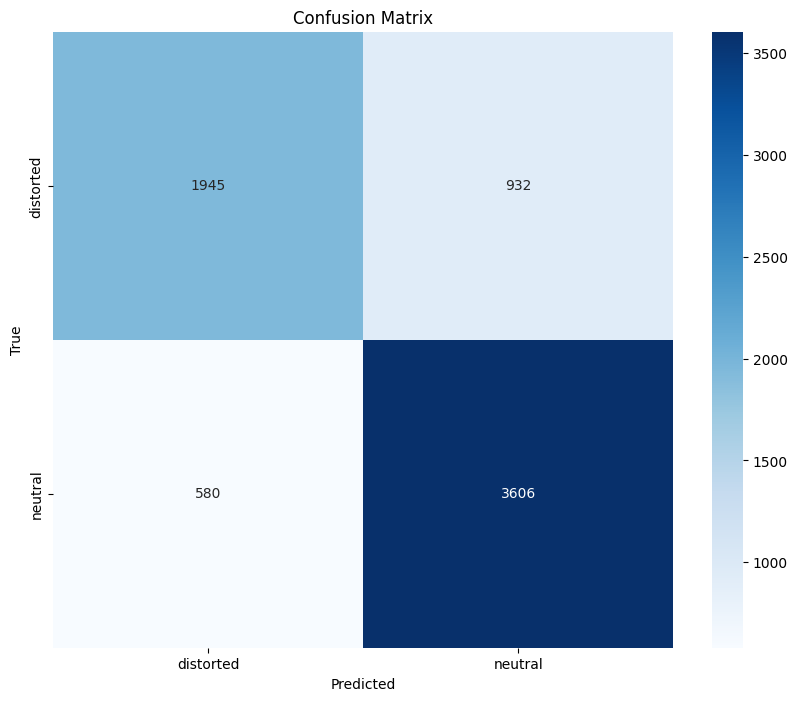

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


,sentence,WE_Sub_BERT,SR_RI,BT_Opus_MT


Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/123583 [00:00<?, ? examples/s]

Map:   0%|          | 0/3531 [00:00<?, ? examples/s]

Map:   0%|          | 0/7063 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Training Started!


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,No log,0.465226,0.764041,0.773106,0.762107,0.762107
2,0.594500,0.456744,0.767326,0.768670,0.770320,0.770320
3,0.482400,0.449296,0.774908,0.774722,0.775135,0.775135


Classification Report:
              precision    recall  f1-score   support

   distorted       0.73      0.74      0.74      2877
     neutral       0.82      0.81      0.82      4186

    accuracy                           0.79      7063
   macro avg       0.78      0.78      0.78      7063
weighted avg       0.79      0.79      0.79      7063

Confusion Matrix:


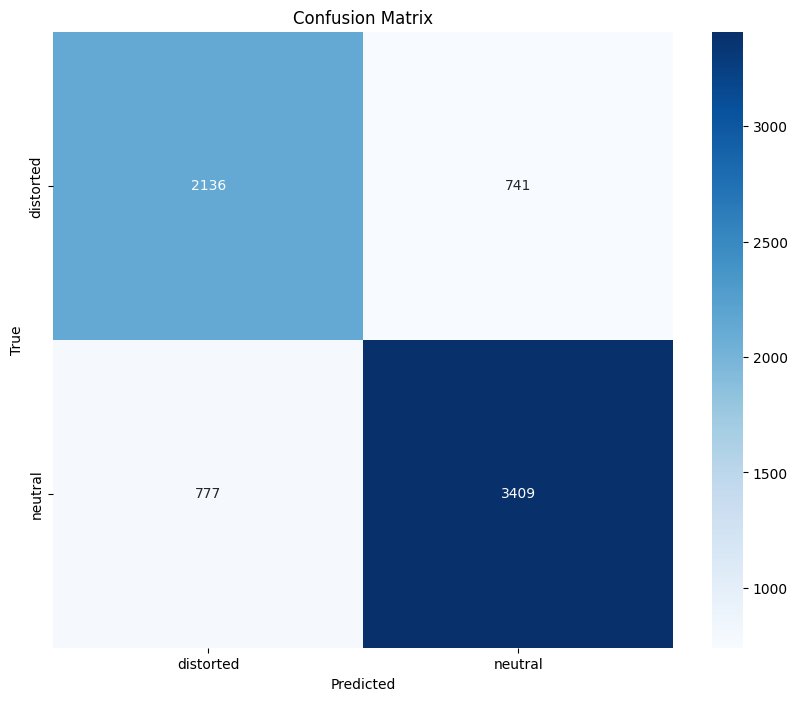

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
df = pd.read_csv(dataset_path)

columns = ['WE_Sub_BERT', 'SR_RI', 'BT_Opus_MT']

dfs = [df]
for r in range(0, 3 + 1):
    combinations_list = []
    combinations_list.extend(combinations(columns, r))
    for comb in combinations_list:
        cols_to_select = ['sentence']
        cols_to_select.extend(list(comb))
        new_df = df[cols_to_select]
        display(new_df.head(0))
        dfs.append(new_df)


        train_set, eval_set, test_set = preprocess_data(df, classification, cols_to_select, val_pct, test_pct) ## return tokenized datasets with labels
        train(train_set, eval_set, test_set)

        torch.cuda.empty_cache()
        !rm /kaggle/working/train.csv /kaggle/working/val.csv /kaggle/working/test.csv
        !rm -rf /kaggle/working/wandb
        !rm -rf /kaggle/working/{out_dir}
